# 計画

第１近似
1. 上下5％をカットした残りからサンプル点を抽出し、５次ベジエ曲線で近似
2. 平均により上下それぞれ中心軸の関数記述を得る。（パラメータを共有していると考えると、中心軸の制御点は左右制御点の重心
3. えられた中心軸関数（５次）に基づいてサンプル点を生成し、３次ベジエ曲線で近似

第２近似
1. 左右対称の輪郭を得るために、中心軸上端、軸の延長上に中心をもつ円で上端輪郭を削る。下端は第１近似と同じ、配置状態で、下から５％を削る。
2. 輪郭点集合が左右に分かれるので、それぞれを５次のベジエ曲線で近似

原型復元
1. 各点に対応する左右輪郭点を求め、軸点と輪郭点の距離を x とする。
2. 中心軸上の各点に対し中心軸の上端（または下端）を基準とした距離を求め、y とする。
3. (x,y) をプロットすることにより対称図形として復元

In [1]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
import cv2
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256

kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
yakumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
aomidamg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



In [17]:
def threeLinesSeqR4(img, showImage =  False, n_samples=20, M=3, N=5, C=4,debugmode=False, openmode=False, precPara1=0.1,precPara2=0.01,cutEnd=5): 
    # M  初期近似での近似次数
    # N 再近似での近似次数
    # C 中心線の近似次数
    # cutEnd  再近似時の上端の削り調整数
    
    #  あらためて輪郭を抽出
    _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    # バウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(img)
    cnt = contours[0] # 白領域は１つしかないという前提なので、０番の輪郭が大根の輪郭である。
    
    # 閉じた輪郭線の上下を削り、左右２本の輪郭に分割する
    canvas = np.zeros_like(img)  # 描画キャンバスの準備
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)     # 輪郭線の描画
    # 上下端それぞれ5％をカットする。上下は歪みが大きいのでノイズとなるので 削除するとともに、それにより輪郭を左右分割する。
    cut05 = y0+int(5*h/100) # シルエッ上端から高さ5％の位置
    cut95 = y0+int(95*h/100) # シルエッ下端から高さ95％の位置

     # 左右のベジエ曲線の平均関数により中心軸のサンプル点を生成し、それをベジエ曲線で近似する関数。
    def getcenterBez(bezXl,bezXr,bezYl,bezYr):
        # 左右のベジエ曲線の平均を求める
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いのでサンプル点を生成して再近似する
        csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # サンプル点を生成
        csamples = np.array(csamples)
        cpxc,cpyc,bezXc,bezYc,tpc = fitBezierCurveN(csamples,precPara=precPara２,N=C,openmode=openmode,debugmode=debugmode)
        return cpxc,cpyc,bezXc,bezYc   
    
    # フェーズ１仮の中心軸を決めるために左右の輪郭の近似記述を得、平均により軸の仮記述とする
    def phase1(): 
        canvas[0:cut05,:]=np.zeros((cut05,img.shape[1])) # 上5%をマスク
        canvas[cut95+1:,:]=np.zeros((img.shape[0]-(cut95+1),img.shape[1]))  # 下5%をマスク
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        # 線図形の輪郭は中間で折り返しになっている（仕様かどうかは不明だがそうなっているようだ）ので折り返しまでを切り出す。
        cnt0 = contours[0][:int(len(contours[0])/2+1)]
        cnt1 = contours[1][:int(len(contours[1])/2+1)]
        # 中程の点を比べて左にある方を左と判定する。
        c0 = cnt0[int(len(cnt0)/2)][0][0]
        c1 = cnt1[int(len(cnt1)/2)][0][0]
        if  c0 > c1: 
            cntL,cntR = cnt1,cnt0
        else:
            cntR,cntL = cnt1,cnt0
        # 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))]
        # findContours の輪郭点は [[x,y]] という風に、座標が２重カッコで囲まれているのでカッコを1組削る
        cntl = np.array([[x,y] for [[x,y]] in cntl])
        cntr = np.array([[x,y] for [[x,y]] in cntr])
        
        # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=precPara1,N=M,openmode=openmode,debugmode=debugmode)
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=precPara1,N=M,openmode=openmode,debugmode=debugmode)
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # cpxc,cpyc,bezXc,bezYc = getcenterBez(bezXl,bezXr,bezYl,bezYr) # この段階ではこれを使ってはいけない

        # 結果の描画
        if showImage:
            tplins50 = np.linspace(0, 1, 50)
            tplins20 = np.linspace(0, 1, 20)
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            # 左輪郭の描画
            plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
            # plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
            #for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
            # 右輪郭の描画
            plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
            #  plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
            #for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
            # 中心軸の描画
            plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
        
            # ラダーの描画
            plot20lx = [bezXl.subs(t,tp) for tp in tplins20 ]
            plot20ly = [bezYl.subs(t,tp) for tp in tplins20 ]
            plot20rx = [bezXr.subs(t,tp) for tp in tplins20 ]
            plot20ry = [bezYr.subs(t,tp) for tp in tplins20 ]
        
            for x0,x1,y0,y1 in zip(plot20lx,plot20rx,plot20ly,plot20ry):
                plt.plot([x0,x1],[y0,y1],color = 'orange') 
        
        return bezXl,bezYl,bezXr,bezYr
    
    bezXl,bezYl,bezXr,bezYr = phase1()
    print('Phase1 finished')
    
    #  得られた仮中心線を基にして輪郭上部をできるだけ軸対称になるような削り方をし、左右輪郭を取り直す
    def phase2(bezXl,bezYl,bezXr,bezYr):
        # 得られ左右輪郭のパラメータの一致する点同士を結んだ線分をその位置での仮の幅として仮の最大幅を求める。
        max_width = 0
        # max_level = 0
        levels = np.linspace(0, 1, 101) # パラメータ空間を１００分割
        for lev in levels:
            xL = bezXl.subs(t,lev)
            yL = bezYl.subs(t,lev)
            xR = bezXr.subs(t,lev)
            yR = bezYr.subs(t,lev)
            w = np.sqrt(float((xL-xR)**2) + float((yL-yR)**2))
            if w > max_width:
                max_width = w
                # max_level = lev
        # ループを抜けると最大幅とその時のパラメータ値が得られている。
    
        # 再び輪郭を描く
        _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
        x0,y0,w,h = cv2.boundingRect(img)
        cnt = contours[0]
        canvas = np.zeros_like(img) # 描画キャンバスの生成
        canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1) # 輪郭線の描画
        
        # 高次のベジエ近似の平均を中心軸の記述に使うと端部の傾きが異常になることが多いので、低次で近似し直す
        cpxc,cpyc,bezXc,bezYc = getcenterBez(bezXl,bezXr,bezYl,bezYr) # 中心軸のベジエ近似  
        # 中心軸を元に左右の輪郭を再度求め直す
        cntL,cntR = segmentLR(img,cnt,bezXc,bezYc,bezXl,bezXr,dmax=max_width,cutEnd=cutEnd,bottomcutLevel=cut95)
        return cntL,cntR
    
    cntL,cntR = phase2(bezXl,bezYl,bezXr,bezYr)
    print('Phase2 finished')
    
    # 再近似
    def phase3(cntL,cntR):
        # 左右をそれぞれ５次のベジエ 曲線で近似し、あらためて中心線と最大幅を得る。
        # リサンプリング
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))] 
        # 再ベジエ 近似
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=precPara2,N=N,openmode=openmode,debugmode=debugmode)
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=precPara2,N=N,openmode=openmode,debugmode=debugmode)
        return cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr
    cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr = phase3(cntL = cntL,cntR= cntR)
    print('Phase3 finished')
    
    # 中心軸に等間隔にサンプル点を取り、その点での法線の方程式に輪郭のベジエ 表現式を代入して５次方程式を解き、
    # 法線と左右の輪郭の交点を求める。
    def phase4(bezXr,bezYr,bezXl,bezYl):
        ## 左右のベジエ曲線の平均を求める
        # bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        ## 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いので次数を減らすためにサンプル点を生成して3次で近似する
        # csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # 20のサンプル点を生成
        # csamples = np.array(csamples)
        print("中心軸の最終決定")
        cpxc,cpyc,bezXc,bezYc = getcenterBez(bezXl,bezXr,bezYl,bezYr)

        # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
        PlistL,PlistR = [],[]
        x0,y0 = var('x0,y0')
        for i in np.linspace(0, 1, n_samples):
            y0 = float(bezYc.subs(t,i))
            x0 = float(bezXc.subs(t,i))
            dx = float(diff(bezXc,t).subs(t,i)) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = float(diff(bezYc,t).subs(t,i))
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] 
            # ↑理論的には、im(i) == 0  でいいのだが、数値計算誤差で虚部が０とならず、微小な値となる現象に現実的な対応
            s = [i for i in ansR if  i<=1.03 and -0.03<=i] # ０から１までの範囲の解を抽出
            PlistR.append(s)          
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00000001]
            s = [i for i in ansL if  i<=1.03 and -0.03<=i]
            PlistL.append(s)
           
        #結果の描画
        if showImage:
            tplins50 = np.linspace(0, 1, 50)
            tplins20 = np.linspace(0, 1, 20)
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))

            # 左輪郭の描画
            plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            # plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
            for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))

            # 右輪郭の描画
            plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            #plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
            for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
            # 中心軸の描画
            plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
        
            # 幅線の描画
            plot20lx = [bezXl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL ]
            plot20ly = [bezYl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL]
            plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, n_samples) ]
            plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, n_samples) ]
            plot20rx = [bezXr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
            plot20ry = [bezYr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
                  
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != [] and y0 !=[]:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != [] and y0 !=[]:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
    
        return cpxc,cpyc,bezXc,bezYc,PlistL,PlistR # radiusTable
    cpxc,cpyc,bezXc,bezYc,PlistL,PlistR = phase4(bezXr,bezYr,bezXl,bezYl)
    print('Phase4 finished')
    
    # 曲がりのない形状を計算する
    def phase5(cnt,PlistL,PlistR,bezXc,bezYc,bezXl,bezYl,bezXr,bezYr):
        # 中心軸と実輪郭の交点を求めて、上端の削除された長さを求める
        cnt = contours[0] # 白領域は１つしかないという前提なので、０番の輪郭が大根の輪郭である。
        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, contours, -1, 1, thickness=1)     # 輪郭線の描画
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,1)
        canvas = canvas1 + canvas2
        ys,xs = np.where(canvas==2)  # 重なった場所は値が２となっている
        if len(ys) ==0: # 運悪く斜めに交差して交点がなかった場合、１ピクセルだけずらす
            canvas = canvas1[1:]+canvas2[0:-1]
            ys,xs = np.where(canvas==2)  
        crosspx = xs[0]
        crosspy = ys[0]
        caplength = np.sqrt((crosspx-x0)**2+(crosspy-y0)**2) # 削られた分の長さ
        print("CAP(近似除外上端部)　{0:0.1f}".format(caplength))
        
        # 定積分により軸に沿った長さを求める
        s = var('s')
        dxdt = diff(bezXc,t)
        dydt = diff(bezYc,t)
        leng = integrate(sqrt(dxdt**2+dydt**2),(t,0,s)) # 長さをパラメータの関数として求める計算式
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,n_samples)):
            cx,cy = bezXc.subs(t,tpara),bezYc.subs(t,tpara)
            length = float(leng.subs(s,tpara))+caplength # 上端からの長さ
            if PlistL[i] != [] and PlistR[i] != []:
                lx,ly = bezXl.subs(t,PlistL[i][0]),bezYl.subs(t,PlistL[i][0])
                rx,ry = bezXr.subs(t,PlistR[i][0]),bezYr.subs(t,PlistR[i][0])
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = (ll+rl)/2 # 半径
            elif PlistL[i] == [] and PlistR[i] != []:
                rx,ry = bezXr.subs(t,PlistR[i][0]),bezYr.subs(t,PlistR[i][0])
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = rl # 半径
            elif PlistL[i] != [] and PlistR[i] == []:
                lx,ly = bezXl.subs(t,PlistL[i][0]),bezYl.subs(t,PlistL[i][0])
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                radishR = ll # 半径
            else:
                radishR = np.inf
            if radishR != np.inf :
                radiusTable.append([radishR,length])
        radiusTable = np.array(radiusTable)
 
        #  延伸形状をベジエ曲線で近似
        cpxl,cpyl,shapeX,shapeY,_tpl = fitBezierCurveN(radiusTable,precPara=precPara2,N=N,openmode=openmode,debugmode=debugmode)
        # 最大径とその位置を求める
        maxrad= 0
        maxpos = 0
        for i in np.linspace(0,1,100):
            x,y = shapeX.subs(t,i),shapeY.subs(t,i)
            if maxrad < x :
                maxrad = x
                maxpos = y
        maxDia = 2*maxrad # 最大直径
                
        radishLength = shapeY.subs(t,1)
        print("ダイコンの長さ={0:0.1f}　　（CAPを含む）".format(float(radishLength)) )
        print("最大直径={0:0.1f} 最大直径の位置は、上端から{1:0.1f} % の位置".format(maxDia,100*maxpos/radishLength))
        
        #結果の描画
        if showImage:
            # plt.figure(figsize=(6,6),dpi=100)
            # plt.gca().invert_yaxis() 
            # plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            tplins50 = np.linspace(0, 1, 50)

            # 輪郭の描画
            plotLx = [shapeX.subs(t,tp) for tp in tplins50 ]
            plotY = [shapeY.subs(t,tp) for tp in tplins50 ]
            plotRx = [-x for x in plotLx]
            plt.plot(plotLx,plotY,color = 'blue')  
            plt.plot(plotRx,plotY,color = 'blue')  
            plt.plot([int(-maxrad),int(maxrad)],[maxpos,maxpos],color = 'red')
     
        return shapeX,shapeY,radishLength, maxDia
    
    radishLength, maxDia, shapeX,shapeY = phase5(cnt,PlistL,PlistR,bezXc,bezYc,bezXl,bezYl,bezXr,bezYr)
        
    return radishLength, maxDia, shapeX,shapeY

# 中心軸情報をもとに輪郭データを左右に分ける
def segmentLR(img,cnt,bezX,bezY,bezXl,bezXr,dmax,cutEnd=5,bottomcutLevel = 10):
    # あらためて概形画像から輪郭線を抽出
    #  img 画像 サイズの参照だけ
    # bezX,bezY 中心軸近似ベジエ曲線
    # dmax 最大直径
    # tcutRatio上部を削るために描く円の半径に掛ける倍率
    # bottomcutRadius　下部を削るために描く円の半径
    
    # 輪郭線の描画
    canvas = np.zeros_like(img)
    canvas = cv2.drawContours(canvas, cnt, -1, 255, thickness=1)
    # 中心軸の延長で上端から最大径離れた地点を中心に最大直径より少し大きな円を０で描き輪郭を削る。
    dy = float((diff(bezY,t)).subs(t,0.05))
    dx = float((diff(bezX,t)).subs(t,0.05)) # t=0 は境界なので変な値にあることがあるため 0.05 としている
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezX.subs(t,0) #  軸の再上端
    y00 = bezY.subs(t,0)
    xdd = dmax*dx/sqrt(dx**2+dy**2) # x方向にこれだけ進むと dmax 離れる
    x11 = x00-xdd
    y11 =  y00-xdd*acc if acc != np.inf else y00-dmax 
    xl0,xr0=bezXl.subs(t,0),bezXr.subs(t,0) # 最初のサンプル輪郭の左右の上端
    ref_x = xl0 if acc >0 else xr0 
    dia = np.sqrt(float(ref_x-x11)**2+float(y11-y00)**2)+cutEnd
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia),0,-1)
    # 下端を削る
    canvas[bottomcutLevel+1:,:]=np.zeros((img.shape[0]-(bottomcutLevel+1),img.shape[1])) 
        
    plt.figure(figsize=(6,6),dpi=100)    
    plt.imshow(canvas)
    
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntL,cntR = cnt1,cnt0
    else:
        cntR,cntL = cnt1,cnt0
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR

Phase1 finished
左輪郭点の数  234 　右輪郭点の数　 225
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　11.5
ダイコンの長さ=241.5　　（CAPを含む）
最大直径=85.2 最大直径の位置は、上端から41.5 % の位置


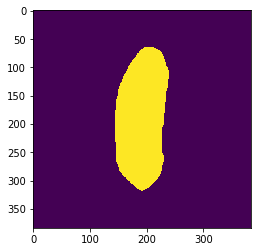

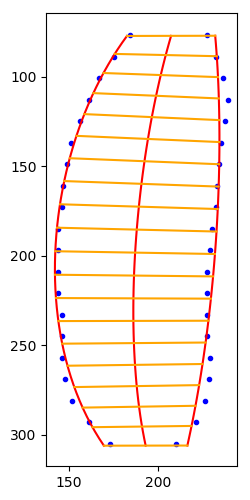

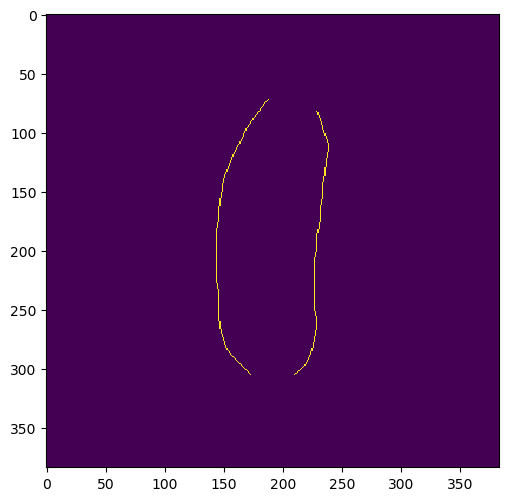

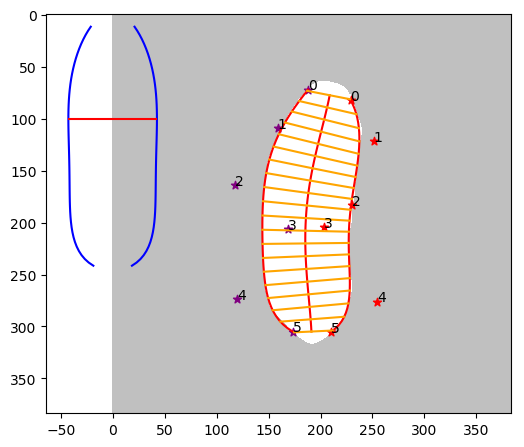

In [3]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][0]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, debugmode=False, openmode=True);

Phase1 finished
左輪郭点の数  237 　右輪郭点の数　 245
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　13.6
ダイコンの長さ=247.4　　（CAPを含む）
最大直径=168.8 最大直径の位置は、上端から35.5 % の位置


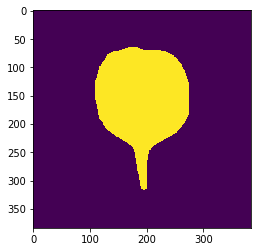

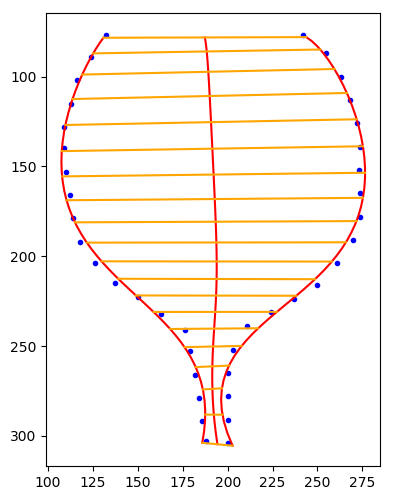

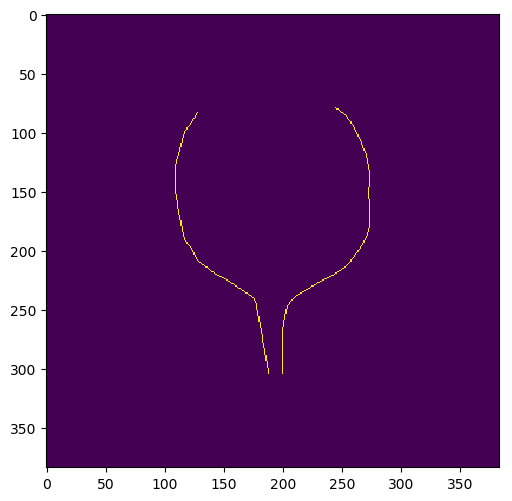

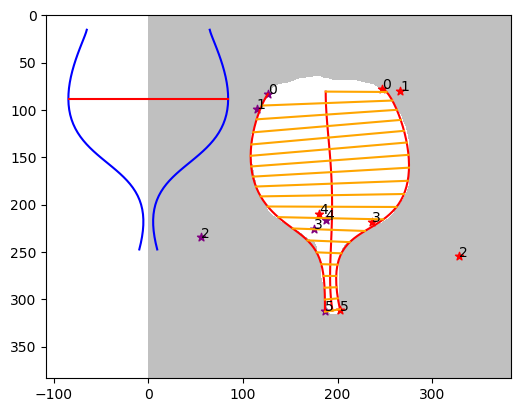

In [4]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][1]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, M=5,N=5, debugmode=False, openmode=True);

### 標本点の数、初期近似、オープンモードのバリエーション

Phase1 finished
左輪郭点の数  238 　右輪郭点の数　 259
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　12.7
ダイコンの長さ=240.7　　（CAPを含む）
最大直径=168.6 最大直径の位置は、上端から37.1 % の位置


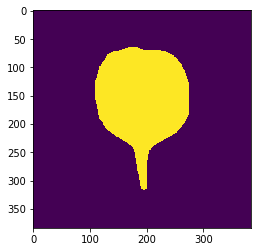

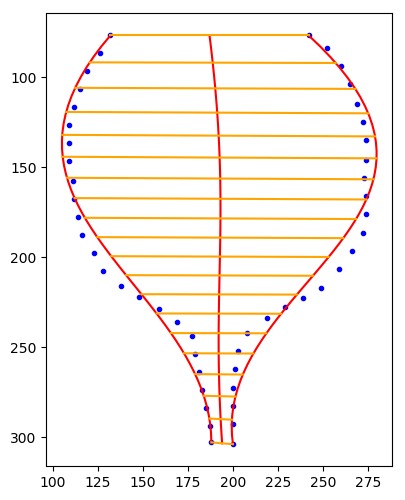

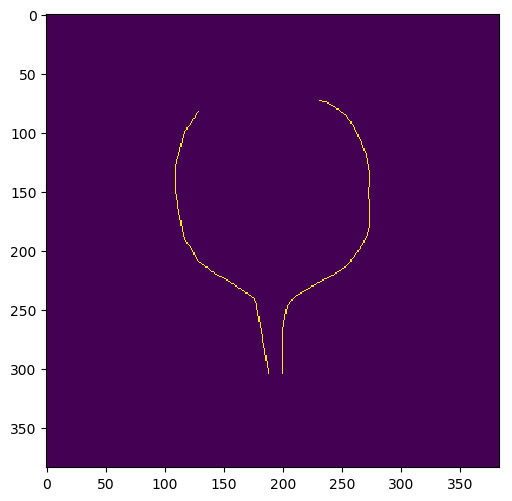

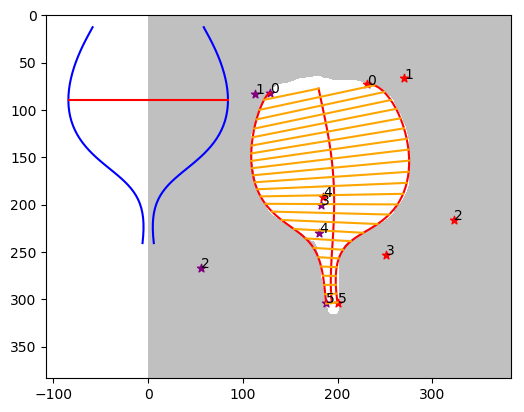

In [5]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][1]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=25, N=5, debugmode=False, openmode=False);

Phase1 finished
左輪郭点の数  262 　右輪郭点の数　 252
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　14.7
ダイコンの長さ=239.3　　（CAPを含む）
最大直径=122.2 最大直径の位置は、上端から79.6 % の位置


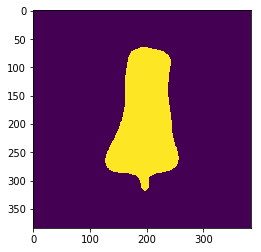

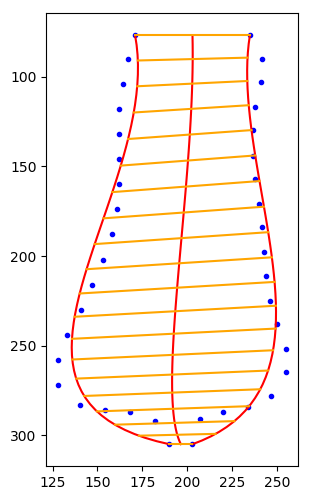

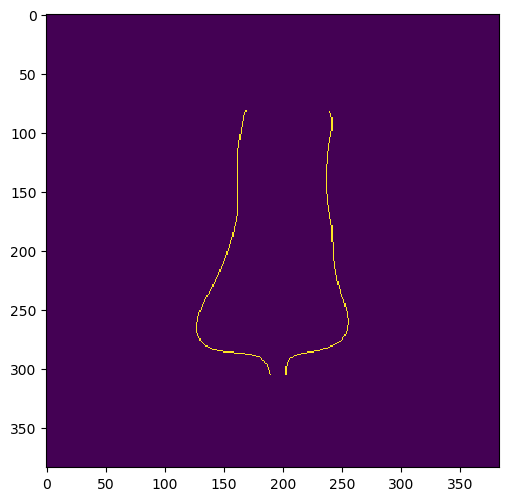

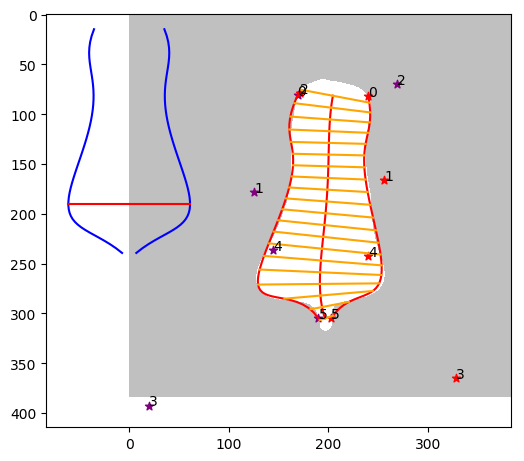

In [6]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][2]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, debugmode=False, openmode=False);

Phase1 finished
左輪郭点の数  220 　右輪郭点の数　 234
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
[] [] <class 'numpy.ndarray'>
CAP(近似除外上端部)　9.6
ダイコンの長さ=251.9　　（CAPを含む）
最大直径=20.8 最大直径の位置は、上端から22.3 % の位置


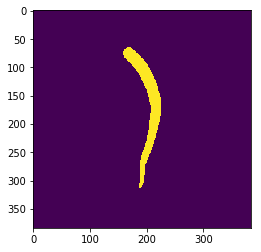

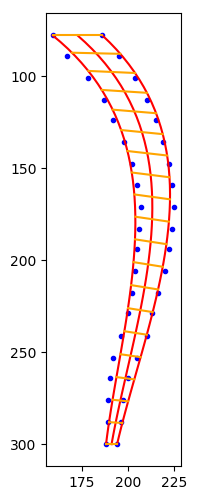

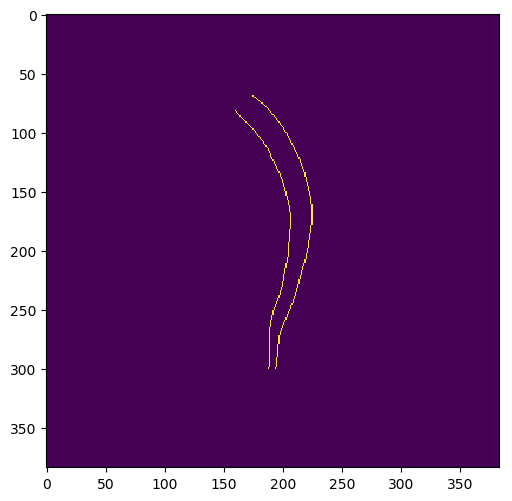

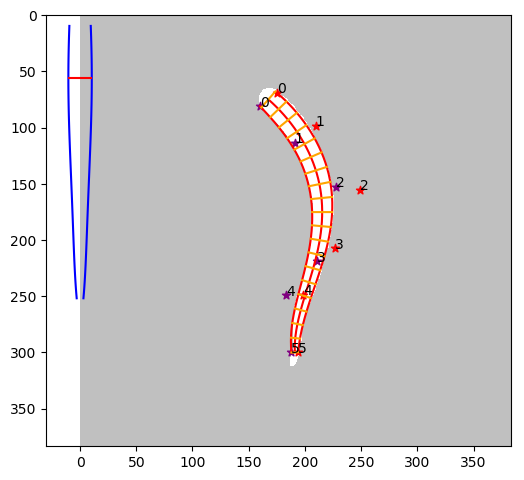

In [16]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][3]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=5, debugmode=False, openmode=False);

# 近似次数での結果の違い
## 2次

Phase1 finished
左輪郭点の数  232 　右輪郭点の数　 225
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　12.5
ダイコンの長さ=241.8　　（CAPを含む）
最大直径=91.6 最大直径の位置は、上端から51.4 % の位置


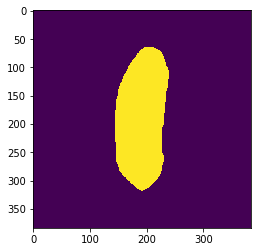

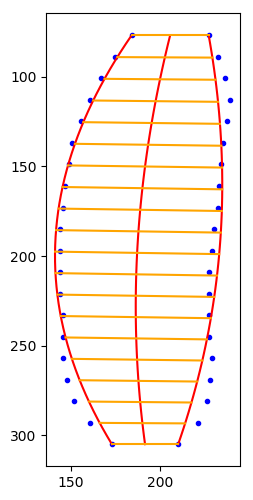

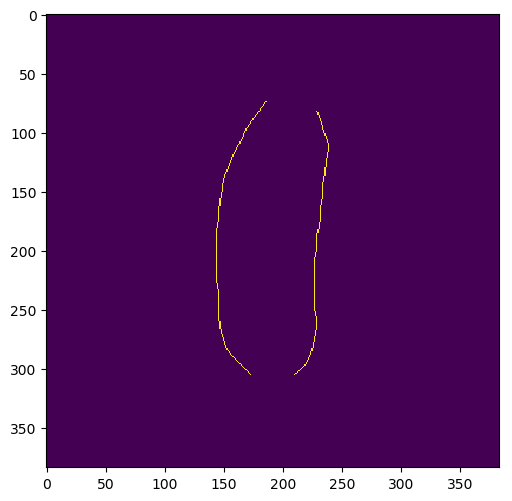

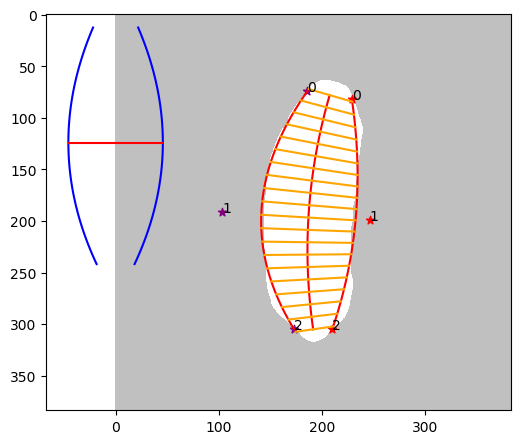

In [18]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][0]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=2, M=2,C=2, debugmode=False, openmode=False);

# 輪郭３次、軸２次

Phase1 finished
左輪郭点の数  232 　右輪郭点の数　 225
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　12.5
ダイコンの長さ=241.8　　（CAPを含む）
最大直径=91.5 最大直径の位置は、上端から55.8 % の位置


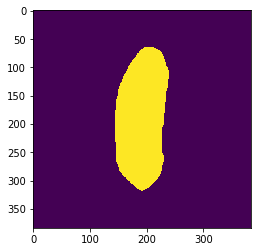

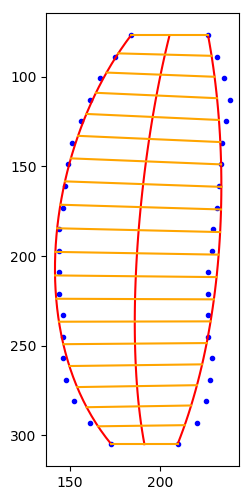

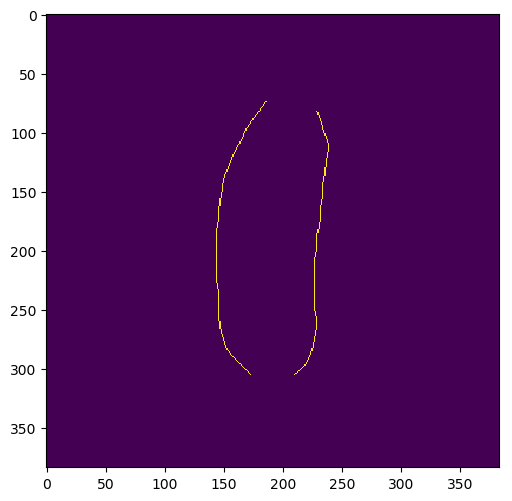

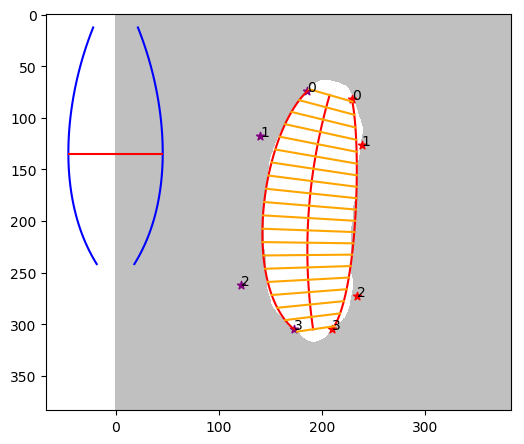

In [19]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][0]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=3, M=3,C=2, debugmode=False, openmode=False);

# 4次

Phase1 finished
左輪郭点の数  232 　右輪郭点の数　 225
Phase2 finished
Phase3 finished
中心軸の最終決定
Phase4 finished
CAP(近似除外上端部)　12.3
ダイコンの長さ=241.5　　（CAPを含む）
最大直径=84.9 最大直径の位置は、上端から67.7 % の位置


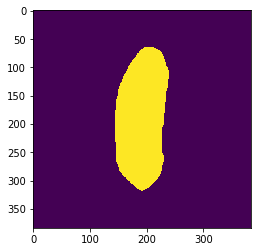

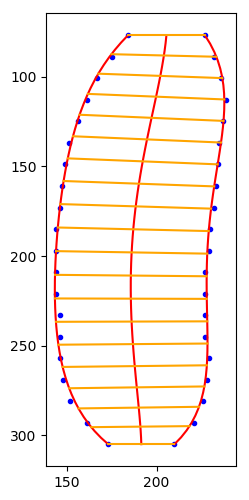

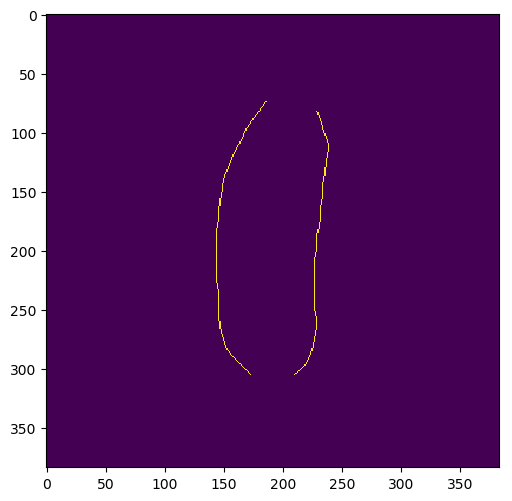

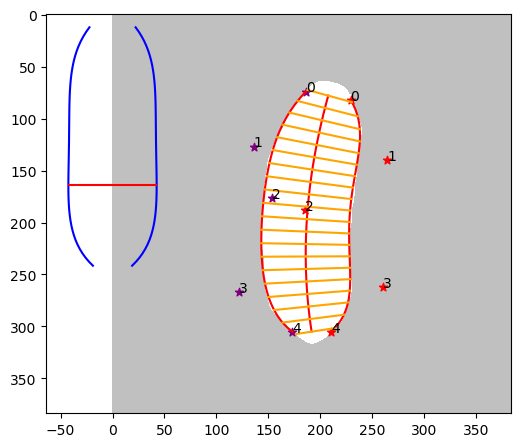

In [20]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][0]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=20, N=4, M=4,C=3, debugmode=False, openmode=False);

# 例外的な失敗例

次の例は、２次ベジエ近似でオープンモード（両端フリー）で実行したケースであるが、上端の制御点がサンプル点よりかなり上寄りに移動してしまった。再サンプリングの際に上端を均等に削ることで左右の輪郭を分けるのだが、その際に上端制御点の位置を基準としているため、この例では上端を削るのに失敗し、輪郭が左右に分割されていない。それ以降の処理は左右分割が前提となっているので、そこから後前提が崩れてエラーとなった。

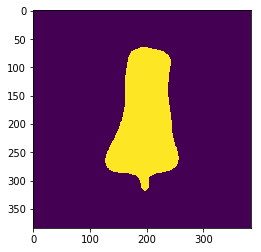

In [21]:
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img);

Phase1 finished


IndexError: list index out of range

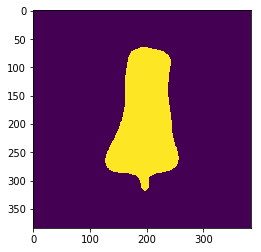

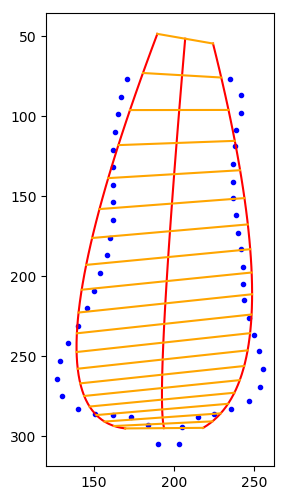

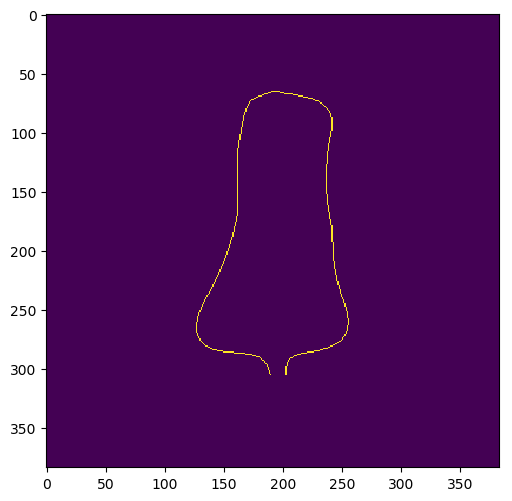

In [22]:
img=[kohakuimg,yakumiimg ,darumaimg,aomidamg][2]
plt.imshow(img)
threeLinesSeqR4(img, showImage =True, n_samples=25, N=2, M=2,C=2, debugmode=False, openmode=True);